# Conditional Metrics

This code shows how to use conditional metrics 

We will evaluate on compas and explore the hypothesis that different racial biases can be attributed to varying age demographics among the different ethnicities.

We don't find any meaningful evidence of this.

We will use the quantization of age provided by the original dataset and divide age into three discrete bins: 'Greater than 45', '25 - 45', and 'Less than 25'.

Owing to limited data, we will merge 'Hispanic', 'Native American', 'Asian', and 'Other' into one group 'Other'. Merging groups purely for lack of data, rather than because you know they are similar, is not advised in real analysis, but it's good enough for a toy example.

This leaves us with three labelled ethnicities 'Caucasian'; 'African American', and 'Other'.

Remeber that this dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats.


In [1]:
# Load the libraries
import oxonfair as fair
from oxonfair import conditional_group_metrics as cgm
from oxonfair import group_metrics as gm
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from oxonfair import dataset_loader
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Split data into train and test only.
train, _, test = dataset_loader.compas('race', train_proportion=0.75, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train['data']['age_cat']=2*train['data']['age_cat']+train['data']['sex']


(array([2772.,    0.,    0.,    0.,    0., 1840.,    0.,    0.,    0.,
         798.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

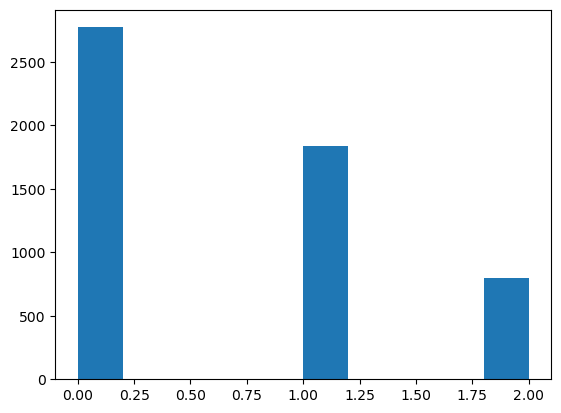

In [3]:
# Plot the histograms for the training data in the column labelled race.
# In order to make the data work with sklearn classifiers, the dataset loader has already replaced the text labels with an ordinal encoding.
# 0 corresponds to 'African American'; 1 'Caucasian' and 2 'Other'
plt.hist(train['data']['race'])

In [4]:
# Now we train a boosted classifier on the data.
pred = XGBClassifier().fit(train['data'], train['target'])


In [5]:
# We will define a fair classifier that can also condition on the 'age_catagory'
fpred = fair.FairPredictor(pred,train,conditioning_factor='age_cat')

In [6]:
# Evaluating the performance per group we see several things
# The Positive label rate for 'African American' is noticably higher than for other groups, and this is reflected by the prediction rate.
# For other groups we see that the prediction rate is significantly lower than label rate i.e. that the ML system is amplifying the bias already present in the data.
# This leads to a lower recall rate for the other groups -- and would substantially drive any unfairness as measured by demographic parity or equal opportunity. 
fpred.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.747135           0.737498  0.695187  0.487175   
         0                   0.743506           0.744158  0.743229  0.488347   
         1                   0.741848           0.703497  0.614761  0.444468   
         2                   0.771930           0.718791  0.625514  0.486555   
         Maximum difference  0.030082           0.040661  0.128468  0.043879   
updated  Overall             0.747135           0.737498  0.695187  0.487175   
         0                   0.743506           0.744158  0.743229  0.488347   
         1                   0.741848           0.703497  0.614761  0.444468   
         2                   0.771930           0.718791  0.625514  0.486555   
         Maximum difference  0.030082           0.040661  0.128468  0.043879   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.760976  0.639869  0.827111          2438.0   
         0                    0.766195  0.721599  0.831735          1426.0   
         1                    0.744597  0.523481  0.807185           724.0   
         2                    0.767677  0.527778  0.826852           288.0   
         Maximum difference   0.023080  0.198118  0.024550          1138.0   
updated  Overall              0.760976  0.639869  0.827111          2438.0   
         0                    0.766195  0.721599  0.831735          1426.0   
         1                    0.744597  0.523481  0.807185           724.0   
         2                    0.767677  0.527778  0.826852           288.0   
         Maximum difference   0.023080  0.198118  0.024550          1138.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     2972.0             0.450647   
         0                           1346.0             0.514430   
         1                           1116.0             0.393478   
         2                            510.0             0.360902   
         Maximum difference           836.0             0.153528   
updated  Overall                     2972.0             0.450647   
         0                           1346.0             0.514430   
         1                           1116.0             0.393478   
         2                            510.0             0.360902   
         Maximum difference           836.0             0.153528   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.378928  
         0                                   0.484488  
         1                                   0.276630  
         2                                   0.248120  
         Maximum difference                  0.236367  
updated  Overall                             0.378928  
         0                                   0.484488  
         1                                   0.276630  
         2                                   0.248120  
         Maximum difference                  0.236367

In [7]:
# Conditioning on age we find very similar numbers
# The Conditional label rate and conditional prediction rates are similar, and the conditional true positive rate (corresponding to recall) is very close to the true recall.
fpred.evaluate_groups(metrics=cgm.cond_measures)

Conditional Accuracy  \
         Groups                                     
original Overall                         0.748832   
         0                               0.749213   
         1                               0.737852   
         2                               0.772822   
         Maximum difference              0.034970   
updated  Overall                         0.748832   
         0                               0.749213   
         1                               0.737852   
         2                               0.772822   
         Maximum difference              0.034970   

                             Conditional True Positive Rate  \
         Groups                                               
original Overall                                   0.634104   
         0                                         0.730037   
         1                                         0.492138   
         2                                         0.535202   
         Maximum difference                        0.237899   
updated  Overall                                   0.634104   
         0                                         0.730037   
         1                                         0.492138   
         2                                         0.535202   
         Maximum difference                        0.237899   

                             Conditional True Negative Rate  \
         Groups                                               
original Overall                                   0.834056   
         0                                         0.751997   
         1                                         0.898449   
         2                                         0.909368   
         Maximum difference                        0.157371   
updated  Overall                                   0.834056   
         0                                         0.751997   
         1                                         0.898449   
         2                                         0.909368   
         Maximum difference                        0.157371   

                             Conditional False Positive Rate  \
         Groups                                                
original Overall                                    0.165944   
         0                                          0.248003   
         1                                          0.101551   
         2                                          0.090632   
         Maximum difference                         0.157371   
updated  Overall                                    0.165944   
         0                                          0.248003   
         1                                          0.101551   
         2                                          0.090632   
         Maximum difference                         0.157371   

                             Conditional False Negative Rate  \
         Groups                                                
original Overall                                    0.358964   
         0                                          0.270740   
         1                                          0.499850   
         2                                          0.478956   
         Maximum difference                         0.229110   
updated  Overall                                    0.358964   
         0                                          0.270740   
         1                                          0.499850   
         2                                          0.478956   
         Maximum difference                         0.229110   

                             Conditional Positive Label Rate  \
         Groups                                                
original Overall                                    0.448838   
         0                                          0.499396   
         1                                          0.410458   
         2          

In [8]:
# We can also evaluate using the conditional metrics proposed by Wachter et al in https://arxiv.org/pdf/2005.05906
# Here the (conditional) proportion of each group in the pool of people with positive labels or negative labels is computed.
# If the proportion a particular group in the pool of positive labels is higher than in the negative pool (i.e a positive difference) this indicates a bias towards positive labels for this group.
# The analysis can be done for target labels (AKA ground-truth) and for the predictions made by an ML system.
# The results are consistent with the previous table. i.e. a strong bias towards positive labels for African-Americans; which is further amplified by the ML classifier.
fpred.evaluate_groups(metrics=cgm.wachter_measures)

Conditional Proportion of Positive Labels  \
         Groups                                                          
original Overall                                              1.000000   
         0                                                    0.570100   
         1                                                    0.311028   
         2                                                    0.118872   
         Maximum difference                                   0.451228   
updated  Overall                                              1.000000   
         0                                                    0.570100   
         1                                                    0.311028   
         2                                                    0.118872   
         Maximum difference                                   0.451228   

                             Conditional Proportion of Negative Labels  \
         Groups                                                          
original Overall                                              1.000000   
         0                                                    0.465384   
         1                                                    0.363795   
         2                                                    0.170821   
         Maximum difference                                   0.294562   
updated  Overall                                              1.000000   
         0                                                    0.465384   
         1                                                    0.363795   
         2                                                    0.170821   
         Maximum difference                                   0.294562   

                             Conditional Difference of Proportion of Labels  \
         Groups                                                               
original Overall                                                   0.000000   
         0                                                         0.104716   
         1                                                        -0.052767   
         2                                                        -0.051949   
         Maximum difference                                        0.157484   
updated  Overall                                                   0.000000   
         0                                                         0.104716   
         1                                                        -0.052767   
         2                                                        -0.051949   
         Maximum difference                                        0.157484   

                             Conditional Proportion of Positive Preditions  \
         Groups                                                              
original Overall                                                  1.000000   
         0                                                        0.628219   
         1                                                        0.273528   
         2                                                        0.098253   
         Maximum difference                                       0.529966   
updated  Overall                                                  1.000000   
         0                                                        0.628219   
         1                                                        0.273528   
         2                                                        0.098253   
         Maximum difference                                       0.529966   

                             Conditional Proportion of Negative Predictions  \
         Groups                                                               
original Overall                                                   1.000000   
         0                                                         0.442750   
         1                                       

In [9]:
# Evaluating the unconditional form, we see much the same pattern
# As such, for a wide range of metrics, conditioning on age does not systematically alter them.
fpred.evaluate_groups(metrics=gm.wachter_measures)

Proportion of Positive Labels  \
         Groups                                              
original Overall                                  1.000000   
         0                                        0.584906   
         1                                        0.296965   
         2                                        0.118130   
         Maximum difference                       0.466776   
updated  Overall                                  1.000000   
         0                                        0.584906   
         1                                        0.296965   
         2                                        0.118130   
         Maximum difference                       0.466776   

                             Proportion of Negative Labels  \
         Groups                                              
original Overall                                  1.000000   
         0                                        0.452894   
         1                                        0.375505   
         2                                        0.171602   
         Maximum difference                       0.281292   
updated  Overall                                  1.000000   
         0                                        0.452894   
         1                                        0.375505   
         2                                        0.171602   
         Maximum difference                       0.281292   

                             Difference of Proportion of Labels  \
         Groups                                                   
original Overall                                       0.000000   
         0                                             0.132012   
         1                                            -0.078540   
         2                                            -0.053472   
         Maximum difference                            0.210552   
updated  Overall                                       0.000000   
         0                                             0.132012   
         1                                            -0.078540   
         2                                            -0.053472   
         Maximum difference                            0.210552   

                             Proportion of Positive Preditions  \
         Groups                                                  
original Overall                                      1.000000   
         0                                            0.655122   
         1                                            0.248293   
         2                                            0.096585   
         Maximum difference                           0.558537   
updated  Overall                                      1.000000   
         0                                            0.655122   
         1                                            0.248293   
         2                                            0.096585   
         Maximum difference                           0.558537   

                             Proportion of Negative Predictions  \
         Groups                                                   
original Overall                                       1.000000   
         0                                             0.425298   
         1                                             0.396131   
         2                                             0.178571   
         Maximum difference                            0.246726   
updated  Overall                                       1.000000   
         0                                             0.425298   
         1                                             0.396131   
         2                                             0.178571   
         Maximum difference                            0.246726   

                             Difference of Proportions of Predictions  
         Groups                                                 